In [55]:
# Modèle théorique d'estimation des émissions sur le périphérique parisien
# Inspiré de la décomposition de Bigo (2020)

# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider

In [56]:
# --- Paramètres par défaut ---
def default_params():
    return {
        "distance_moyenne_km": 35,
        "nb_usagers_jour": 1_000_000,
        "part_voitures_thermiques": 0.7,
        "part_voitures_diesel": 0.2,
        "part_voitures_elec": 0.1,
        "conso_l_100km_essence_70": 7.0,
        "conso_l_100km_essence_50": 6.5,
        "conso_l_100km_diesel_70": 5.5,
        "conso_l_100km_diesel_50": 5.0,
        "conso_kWh_100km_elec_70": 17.0,
        "conso_kWh_100km_elec_50": 15.5,
        "emission_CO2_l_essence": 2.3,
        "emission_CO2_l_diesel": 2.6,
        "emission_CO2_kWh": 0.012,
        "emission_NOx_g_km_essence": 0.25,
        "emission_NOx_g_km_diesel": 0.6,
        "emission_NOx_g_km_elec": 0.01,
        "emission_PM10_g_km_essence": 0.01,
        "emission_PM10_g_km_diesel": 0.05,
        "emission_PM10_g_km_elec": 0.005,
        "taux_remplissage_actuel": 1.2,
        "taux_remplissage_covoit": 1.8,
        "part_covoiturage": 0.2,
        "duree_jours": 365,
        "part_temps_pointe": 0.31,
        "part_poids_lourd": 0.03
    }

In [57]:
def facteur_congestion(nb_vehicules, seuil, seuil_max, nb_voies):
    """
    Estime un facteur de surconsommation lié à la congestion, en fonction
    de la densité de trafic par voie.

    Le facteur renvoyé est utilisé pour ajuster la consommation énergétique 
    (carburant ou électricité) des véhicules lorsque la densité de trafic 
    augmente.

    Paramètres :
    - nb_vehicules : nombre total de véhicules sur le tronçon considéré
    - seuil : seuil de densité (veh/voie) à partir duquel la consommation commence à augmenter
    - seuil_max : densité à partir de laquelle la congestion est considérée comme forte
    - nb_voies : nombre de voies disponibles pour les véhicules considérés

    Retour :
    - Un facteur multiplicatif appliqué à la consommation (1.0 = trafic fluide, >1.0 = congestion)
    
    Comportement :
    - Si densité ≤ seuil        → consommation normale (facteur = 1.0)
    - Si seuil < densité ≤ max  → surconsommation modérée (croissance linéaire)
    - Si densité > seuil_max    → surconsommation sévère (facteur > 1.1)
    """

    densite = nb_vehicules / nb_voies

    if densite <= seuil:
        return 1.0
    elif densite <= seuil_max:
        return 1.0 + 0.1 * (densite - seuil) / (seuil_max - seuil)
    else:
        return 1.1 + 0.1 * (densite - seuil_max) / seuil_max

In [58]:
def get_vehicule_data(params, type_v, vitesse_reduite):
    if type_v == "essence":
        conso = params["conso_l_100km_essence_50"] if vitesse_reduite else params["conso_l_100km_essence_70"]
        return conso, params["emission_CO2_l_essence"], params["emission_NOx_g_km_essence"], params["emission_PM10_g_km_essence"]
    elif type_v == "diesel":
        conso = params["conso_l_100km_diesel_50"] if vitesse_reduite else params["conso_l_100km_diesel_70"]
        return conso, params["emission_CO2_l_diesel"], params["emission_NOx_g_km_diesel"], params["emission_PM10_g_km_diesel"]
    else:
        conso = params["conso_kWh_100km_elec_50"] if vitesse_reduite else params["conso_kWh_100km_elec_70"]
        return conso, params["emission_CO2_kWh"], params["emission_NOx_g_km_elec"], params["emission_PM10_g_km_elec"]

In [59]:
def capacite_theorique_voie_route(params):
    """
    Calcule la capacité horaire maximale d'une route selon une formule empirique --> https://tunnels.piarc.org/sites/tunnels/files/public/wysiwyg/import/Chapters%20PIARC%20reports/2001%2005.11.B%20Chap%204%20FR.pdf 

    - N : nombre de voies
    - Cl : coefficient de longueur
    - Cpl : coefficient de placement (accès latéraux)
    - Cc : coefficient de conditions

    Retourne :
    - capacité_journalière maximale en véhicules/jour
    """
    Cl = 1.0
    Cc = 1.0
    Cpl = (1 + params["part_poids_lourd"] * 0.5) ** -1
    capacite_horaire = 2200 * Cl * Cpl * Cc                 #on ne multiplie par par le nombre de voie car on le fait plus tard dans le code, pour différencier les scénarios de activation ou non activation de la voie de covoiturage
    capacite_journaliere = capacite_horaire * 24
    return capacite_journaliere

In [60]:
def calcul_seuils_congestion(params, nb_voies):
    """
    Calcule les seuils de congestion (début et max) en fonction de la capacité de la route.

    - nb_voies : nombre de voies considérées
    - params : dictionnaire contenant 'capacite_par_voie'

    Retourne :
    - seuil : début de congestion (trafic dense)
    - seuil_max : congestion sévère
    """
    
    capacite_voie = capacite_theorique_voie_route(params) #en vhc/h/voie
    seuil = capacite_voie * nb_voies
    seuil_max = capacite_voie * 1.5 * nb_voies  #congestion sévère à +50% du trafic possible
    return seuil, seuil_max

In [61]:
def compute_emissions_for_group(params, n_vehicules, congestion, part_temps, vitesse_reduite):
    d = params["distance_moyenne_km"]
    jours = params["duree_jours"]
    result = {"CO2": 0, "NOx": 0, "PM10": 0}

    for type_v, part_motor in [
        ("essence", params["part_voitures_thermiques"]),
        ("diesel", params["part_voitures_diesel"]),
        ("elec", params["part_voitures_elec"])
    ]:
        conso, CO2e, NOx, PM = get_vehicule_data(params, type_v, vitesse_reduite)
        km_total = part_motor * n_vehicules * d * part_temps
        consommation_totale = km_total * (conso / 100) * congestion

        result["CO2"] += consommation_totale * CO2e / 1000 * jours
        result["NOx"] += km_total * NOx / 1_000_000 * jours
        result["PM10"] += km_total * PM / 1_000_000 * jours

    return result

In [62]:
def calcul_emissions(params, vitesse_reduite=False, part_temps=1.0, voie_covoit_activee=False):
    
    d = params["distance_moyenne_km"]
    jours = params["duree_jours"]
    nb_usagers_jour = params["nb_usagers_jour"]
    D = nb_usagers_jour * d

    part_solo = 1 - params["part_covoiturage"]
    r = 1 / (part_solo + params["part_covoiturage"] / params["taux_remplissage_covoit"])
    n = D / (r * d)
    print(f"\n>>> Nombre de véhicules ajusté : {n:.0f}")

    result = {"CO2": 0, "NOx": 0, "PM10": 0}

    if voie_covoit_activee and part_temps == params["part_temps_pointe"]:
        print(">>> Mode spécial : voie covoiturage activée aux heures de pointe")
        part_prioritaire = min(0.05 + params["part_covoiturage"], 1.0)
        part_classique = 1 - part_prioritaire

        if part_prioritaire >= 0.25:
            print(">>> Trop de véhicules prioritaires : retour à répartition sur 4 voies")
            seuil, seuil_max = calcul_seuils_congestion(params, nb_voies=4)
            congestion = facteur_congestion(n, seuil, seuil_max, nb_voies=4)
            result = compute_emissions_for_group(params, n, congestion, part_temps, vitesse_reduite)
        else:
            n_prio = n * part_prioritaire
            n_class = n * part_classique

            seuil_p, seuil_max_p = calcul_seuils_congestion(params, nb_voies=1)
            seuil_c, seuil_max_c = calcul_seuils_congestion(params, nb_voies=3)

            congestion_p = facteur_congestion(n_prio, seuil_p, seuil_max_p, nb_voies=1)
            congestion_c = facteur_congestion(n_class, seuil_c, seuil_max_c, nb_voies=3)

            print(f"  → part_prioritaire : {part_prioritaire:.4f}")
            print(f"  → densité prio : {n_prio:.0f} / 1 voie")
            print(f"  → densité classique : {n_class:.0f} / 3 voies")
            print(f"  → congestion prio : {congestion_p:.4f}")
            print(f"  → congestion classique : {congestion_c:.4f}")

            res_prio = compute_emissions_for_group(params, n_prio, congestion_p, part_temps, vitesse_reduite)
            res_class = compute_emissions_for_group(params, n_class, congestion_c, part_temps, vitesse_reduite)

            for k in result:
                result[k] = res_prio[k] + res_class[k]
    else:
        seuil, seuil_max = calcul_seuils_congestion(params, nb_voies=4)
        congestion = facteur_congestion(n, seuil, seuil_max, nb_voies=4)
        result = compute_emissions_for_group(params, n, congestion, part_temps, vitesse_reduite)

    # Emissions moyennes par personne
    nb_personnes_total = nb_usagers_jour * jours
    result["CO2_par_personne"] = result["CO2"] * 1000 / nb_personnes_total
    result["NOx_par_personne"] = result["NOx"] * 1_000_000 / nb_personnes_total
    result["PM10_par_personne"] = result["PM10"] * 1_000_000 / nb_personnes_total

    return result

In [63]:
# --- Fusion pointe / hors-pointe ---
def emissions_horaires_combinees(params, vitesse_reduite=False, voie_covoit_activee=False):
    """
    Calcule les émissions annuelles totales (CO₂, NOx, PM10) en distinguant
    les heures de pointe et les heures hors-pointe.

    Cette fonction appelle deux fois la fonction `calcul_emissions` :
    - une première fois pour les heures de pointe (avec ou sans voie de covoiturage activée),
    - une seconde fois pour les heures creuses (toujours sans voie de covoiturage).

    L’intérêt de cette séparation est de refléter les conditions de circulation
    variables au cours de la journée (trafic plus dense, vitesse réduite, effets
    de la voie réservée, etc.).

    PARAMÈTRES :
    ------------
    - params : dictionnaire des paramètres du modèle
    - vitesse_reduite : booléen indiquant si la vitesse est réduite à 50 km/h ou non
    - voie_covoit_activee : booléen indiquant si la voie de covoiturage est activée
      pendant les heures de pointe (inutile hors-pointe)

    MÉCANISME :
    -----------
    - On décompose la journée en deux parties :
        - heures de pointe : proportion définie par `params["part_temps_pointe"]`
        - heures hors-pointe : le reste de la journée
    - Les émissions sont calculées séparément pour chaque période
      en tenant compte du contexte de trafic (ex : covoiturage activé ou non).
    - Les émissions des deux périodes sont ensuite additionnées pour
      obtenir les émissions totales annuelles.

    RETOUR :
    --------
    - Dictionnaire contenant les émissions totales par polluant :
      {"CO2": ..., "NOx": ..., "PM10": ...} en tonnes par an.
    """

    # --- Répartition du temps ---
    part_pointe = params["part_temps_pointe"]  # part du temps journalier en heure de pointe (ex. 0.31)
    part_off = 1 - part_pointe                 # part du temps en heure creuse (hors-pointe)

    # --- Ajustement de la surconsommation aux heures de pointe ---
    # (ancien système — plus utilisé ici, mais laissé par sécurité)
    #surconso_pointe = params["surconso_congestion_pointe"]
    #if voie_covoit_activee:
        # Si la voie covoiturage est active, on réduit un peu la surconsommation estimée
        #surconso_pointe = min(1.05, surconso_pointe - 0.05)

    # --- Calcul des émissions pour les heures de pointe ---
    res_pointe = calcul_emissions(
        params,
        vitesse_reduite=vitesse_reduite,
        part_temps=part_pointe,
        voie_covoit_activee=voie_covoit_activee  # on active la logique des 2 groupes si demandé
    )

    # --- Calcul des émissions pour les heures hors-pointe ---
    res_off = calcul_emissions(
        params,
        vitesse_reduite=vitesse_reduite,
        part_temps=part_off,
        voie_covoit_activee=False  # la voie covoiturage est inactive hors-pointe
    )

    # --- Somme des émissions totales sur l’année ---
    total = {
        k: res_pointe[k] + res_off[k] for k in res_pointe
    }
    return total


In [64]:
import numpy as np
import matplotlib.pyplot as plt

def afficher_resultats(params):
    scenarios = {
        "A. 70 km/h sans voie covoiturage": emissions_horaires_combinees(params, vitesse_reduite=False, voie_covoit_activee=False),
        "B. 50 km/h sans voie covoiturage": emissions_horaires_combinees(params, vitesse_reduite=True, voie_covoit_activee=False),
        "C. 50 km/h avec voie covoiturage": emissions_horaires_combinees(params, vitesse_reduite=True, voie_covoit_activee=True)
    }

    # --- Affichage console des valeurs et variations ---
    base = scenarios["A. 70 km/h sans voie covoiturage"]
    print("\nScénarios comparés (valeurs absolues et % de variation par rapport à A) :")
    for nom, valeurs in scenarios.items():
        print(f"\n{nom} :")
        for polluant in ["CO2", "NOx", "PM10"]:
            val = valeurs[polluant]
            if nom == "A. 70 km/h sans voie covoiturage":
                print(f"  {polluant} : {val:.2f} t/an")
            else:
                ref = base[polluant]
                variation = 100 * (val - ref) / ref
                signe = "+" if variation >= 0 else ""
                print(f"  {polluant} : {val:.2f} t/an ({signe}{variation:.1f}%)")

    # Affichage des émissions par personne
    print("\n--- Émissions moyennes par personne (kg ou g par an) ---")
    for nom, valeurs in scenarios.items():
        print(f"\n{nom} :")
        print(f"  CO2 par personne : {valeurs['CO2_par_personne']:.1f} kg/an")
        print(f"  NOx par personne : {valeurs['NOx_par_personne']:.1f} g/an")
        print(f"  PM10 par personne : {valeurs['PM10_par_personne']:.1f} g/an")

    # --- Données pour les graphes ---
    labels = list(scenarios.keys())
    x = np.arange(len(labels))
    CO2_vals = [scenarios[k]["CO2"] for k in labels]
    NOx_vals = [scenarios[k]["NOx"] for k in labels]
    PM10_vals = [scenarios[k]["PM10"] for k in labels]

    def intervalle_confiance(valeurs, pourcentage=0.02):
        ecart = np.array(valeurs) * pourcentage
        bas = np.array(valeurs) - ecart
        haut = np.array(valeurs) + ecart
        return bas, haut

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # --- CO2 ---
    co2_bas, co2_haut = intervalle_confiance(CO2_vals)
    axes[0].plot(x, CO2_vals, marker='o', color='green')
    axes[0].fill_between(x, co2_bas, co2_haut, color='green', alpha=0.2)
    axes[0].set_title("Émissions de CO₂")
    axes[0].set_ylabel("t/an")
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(labels, rotation=20)

    # --- NOx ---
    nox_bas, nox_haut = intervalle_confiance(NOx_vals)
    axes[1].plot(x, NOx_vals, marker='o', color='orange')
    axes[1].fill_between(x, nox_bas, nox_haut, color='orange', alpha=0.2)
    axes[1].set_title("Émissions de NOx")
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(labels, rotation=20)

    # --- PM10 ---
    pm10_bas, pm10_haut = intervalle_confiance(PM10_vals)
    axes[2].plot(x, PM10_vals, marker='o', color='gray')
    axes[2].fill_between(x, pm10_bas, pm10_haut, color='gray', alpha=0.2)
    axes[2].set_title("Émissions de PM10")
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(labels, rotation=20)

    plt.tight_layout()
    plt.show()

In [ ]:
# --- Interface interactive ---
@interact(
    distance_moyenne_km=FloatSlider(min=10, max=50, step=1, value=35, description="km/jour"),
    nb_usagers_jour=IntSlider(min=100_000, max=2_000_000, step=50_000, value=1_000_000, description="Usagers/jour"),
    part_covoiturage=FloatSlider(min=0.0, max=0.5, step=0.01, value=0.2, description="% covoiturage"),
    surconso_congestion_pointe=FloatSlider(min=1.0, max=1.2, step=0.01, value=1.1, description="Surconso pointe"),
    surconso_congestion_offpointe=FloatSlider(min=1.0, max=1.2, step=0.01, value=1.0, description="Surconso hors-pointe"),
    seuil_congestion=FloatSlider(min=50000, max=200000, step=5000, value=100000, description="Seuil congestion"),
    seuil_max_congestion=FloatSlider(min=100000, max=300000, step=5000, value=200000, description="Seuil max congestion")
)
def simulation_interactive(distance_moyenne_km, nb_usagers_jour, part_covoiturage,
                           surconso_congestion_pointe, surconso_congestion_offpointe,
                           seuil_congestion, seuil_max_congestion):
    params = default_params()
    params.update({
    "distance_moyenne_km": distance_moyenne_km,
    "nb_usagers_jour": nb_usagers_jour,
    "part_covoiturage": part_covoiturage,
    "surconso_congestion_pointe": surconso_congestion_pointe,
    "surconso_congestion_offpointe": surconso_congestion_offpointe,
    "seuil_congestion": seuil_congestion,
    "seuil_max_congestion": seuil_max_congestion
})
    afficher_resultats(params)

interactive(children=(FloatSlider(value=35.0, description='km/jour', max=50.0, min=10.0, step=1.0), IntSlider(…


>>> Nombre de véhicules ajusté : 1000000
>>> Mode spécial : voie covoiturage activée aux heures de pointe
  → part_prioritaire : 0.0500
  → densité prio : 50000 / 1 voie
  → densité classique : 950000 / 3 voies
  → congestion prio : 1.0000
  → congestion classique : 1.1353

>>> Nombre de véhicules ajusté : 1000000

>>> Nombre de véhicules ajusté : 995556
>>> Mode spécial : voie covoiturage activée aux heures de pointe
  → part_prioritaire : 0.0600
  → densité prio : 59733 / 1 voie
  → densité classique : 935822 / 3 voies
  → congestion prio : 1.0297
  → congestion classique : 1.1333

>>> Nombre de véhicules ajusté : 995556

>>> Nombre de véhicules ajusté : 991111
>>> Mode spécial : voie covoiturage activée aux heures de pointe
  → part_prioritaire : 0.0700
  → densité prio : 69378 / 1 voie
  → densité classique : 921733 / 3 voies
  → congestion prio : 1.0667
  → congestion classique : 1.1313

>>> Nombre de véhicules ajusté : 991111

>>> Nombre de véhicules ajusté : 986667
>>> Mode spé

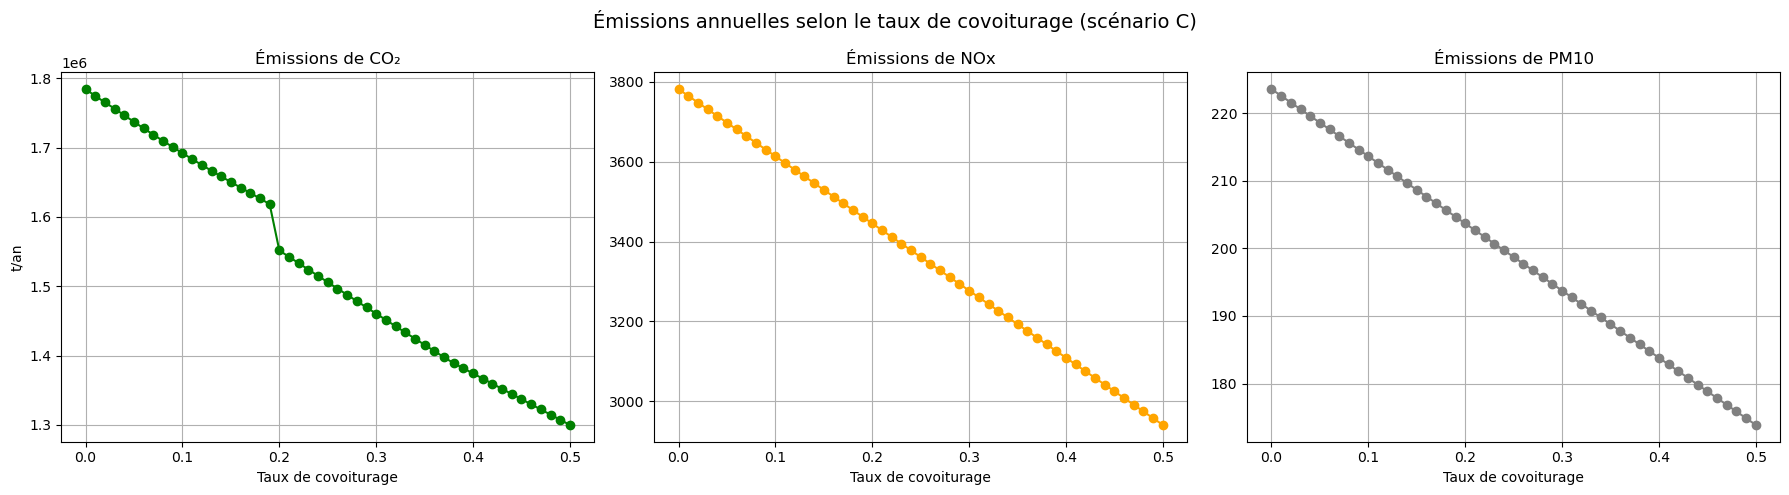

In [66]:
# --- Visualisation des émissions selon le taux de covoiturage ---
covoit_range = np.linspace(0, 0.5, 51)
CO2_vals = []
NOx_vals = []
PM10_vals = []

for cov in covoit_range:
    params = default_params()
    params.update({
        "part_covoiturage": cov,
        "surconso_congestion_pointe": 1.1,
        "surconso_congestion_offpointe": 1.0,
        "seuil_congestion": 100000,
        "seuil_max_congestion": 200000
    })
    emissions = emissions_horaires_combinees(params, vitesse_reduite=True, voie_covoit_activee=True)
    CO2_vals.append(emissions["CO2"])
    NOx_vals.append(emissions["NOx"])
    PM10_vals.append(emissions["PM10"])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(covoit_range, CO2_vals, marker='o', color='green')
axes[0].set_title("Émissions de CO₂")
axes[0].set_xlabel("Taux de covoiturage")
axes[0].set_ylabel("t/an")
axes[0].grid(True)

axes[1].plot(covoit_range, NOx_vals, marker='o', color='orange')
axes[1].set_title("Émissions de NOx")
axes[1].set_xlabel("Taux de covoiturage")
axes[1].grid(True)

axes[2].plot(covoit_range, PM10_vals, marker='o', color='gray')
axes[2].set_title("Émissions de PM10")
axes[2].set_xlabel("Taux de covoiturage")
axes[2].grid(True)

plt.suptitle("Émissions annuelles selon le taux de covoiturage (scénario C)", fontsize=14)
plt.tight_layout()
plt.show()